In [3]:
include("../Source/types.jl")
include("../Source/functions.jl")

mcSweep! (generic function with 1 method)

# Tuples vs. separate ints
It is better to have separate input arguments to functions than to have these in a tuple

In [5]:
using BenchmarkTools
function test!(ψ::State, γ::Float64, g::Float64, ν::Float64, f::Float64)
    ψ.γ = γ
    ψ.g = g
    ψ.ν = ν
    ψ.f = f
    return
end
function test2!(ψ::State, constants::Tuple{Float64, Float64, Float64, Float64})
    (ψ.γ, ψ.g, ψ.ν, ψ.f) = constants
    return
end
ψ = State(40,2)
@benchmark test!(ψ, 4.0, 4.0, 0.3, 1.0/32)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     18.627 ns (0.00% GC)
  median time:      32.120 ns (0.00% GC)
  mean time:        32.544 ns (0.00% GC)
  maximum time:     98.113 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     997

In [6]:
@benchmark test2!(ψ, (4.0, 4.0, 0.3, 1.0/32))

BenchmarkTools.Trial: 
  memory estimate:  48 bytes
  allocs estimate:  1
  --------------
  minimum time:     20.568 ns (0.00% GC)
  median time:      23.217 ns (0.00% GC)
  mean time:        34.395 ns (11.29% GC)
  maximum time:     4.101 μs (93.58% GC)
  --------------
  samples:          10000
  evals/sample:     997

# Call by value is bad in general
It is better to have pointers to lattice sites as function arguments and then use these pointers to find the needed values in the lattice sites, than to have the values as function arguments and finding the values when calling the function.

In [7]:
# -----------------------------------------------------------------------------------------------------------
# Returns the local vorticity by preforming a plaquette sum using the gauge-invariant difference of the θ field.
function n⁺(ψ::State, ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, ϕᵣ₊₁₊₂::LatticeSite, x::Int64)
    return (mod(ϕᵣ₊₁.θ⁺ - ϕ.θ⁺ + ψ.g*ϕ.A[1],two_pi) + mod(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₁.θ⁺ + ψ.g*(ϕᵣ₊₁.A[2] + two_pi*ψ.f*x), two_pi) 
        - mod(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₂.θ⁺ + ψ.g*ϕᵣ₊₂.A[1], two_pi) 
        - mod(ϕᵣ₊₂.θ⁺ - ϕ.θ⁺ + ψ.g*(ϕ.A[2] + two_pi*ψ.f*(x-1)), two_pi))/two_pi
end
# An altenative version that is a bad idea (depricated)
function n⁺2(Δ₁θ::Float64, Δ₂θᵣ₊₁::Float64, Δ₁θᵣ₊₂::Float64, Δ₂θ::Float64,
            Ax::Float64, Ay::Float64, Aᵣ₊₁y::Float64, Aᵣ₊₂x::Float64, g::Float64)
    return (mod(Δ₁θ + g*Ax, two_pi) + mod(Δ₂θᵣ₊₁ + g*Aᵣ₊₁y, two_pi) 
        - mod(Δ₁θᵣ₊₂ + g*Aᵣ₊₂x, two_pi) - mod(Δ₂θ + g*Ay, two_pi))/two_pi
end

n⁺2 (generic function with 1 method)

In [10]:
ψ = State(2, 2)
# First evaluating by the first function
x1 = n⁺(ψ, ψ.lattice[2,1], ψ.lattice[2,2], ψ.lattice[1,1], ψ.lattice[1,2], 1)
# Evaluating by the second function we have to do some calculation in the call
x2 = n⁺2(ψ.lattice[2,2].θ⁺-ψ.lattice[2,1].θ⁺, ψ.lattice[1,2].θ⁺ - ψ.lattice[2,2].θ⁺, 
    ψ.lattice[1,2].θ⁺ - ψ.lattice[1,1].θ⁺, ψ.lattice[1,1].θ⁺ - ψ.lattice[2,1].θ⁺, 
    ψ.lattice[2,1].A[1], ψ.lattice[2,1].A[2] + two_pi*ψ.f*(1-1), 
    ψ.lattice[2, 2].A[2] + two_pi*ψ.f*(2-1), ψ.lattice[1,1].A[1], ψ.g)
println(x1==x2)
@benchmark n⁺(ψ, ψ.lattice[2,1], ψ.lattice[2,2], ψ.lattice[1,1], ψ.lattice[1,2], 1)

true


BenchmarkTools.Trial: 
  memory estimate:  448 bytes
  allocs estimate:  28
  --------------
  minimum time:     608.845 ns (0.00% GC)
  median time:      635.322 ns (0.00% GC)
  mean time:        687.366 ns (2.70% GC)
  maximum time:     10.540 μs (74.62% GC)
  --------------
  samples:          10000
  evals/sample:     174

In [11]:
@benchmark n⁺2(ψ.lattice[2,2].θ⁺-ψ.lattice[2,1].θ⁺, ψ.lattice[1,2].θ⁺ - ψ.lattice[2,2].θ⁺, 
    ψ.lattice[1,2].θ⁺ - ψ.lattice[1,1].θ⁺, ψ.lattice[1,1].θ⁺ - ψ.lattice[2,1].θ⁺, 
    ψ.lattice[2,1].A[1], ψ.lattice[2,1].A[2] + two_pi*ψ.f*(1-1), 
    ψ.lattice[2, 2].A[2] + two_pi*ψ.f*(2-1), ψ.lattice[1,1].A[1], ψ.g)

BenchmarkTools.Trial: 
  memory estimate:  416 bytes
  allocs estimate:  26
  --------------
  minimum time:     949.345 ns (0.00% GC)
  median time:      965.069 ns (0.00% GC)
  mean time:        1.012 μs (1.72% GC)
  maximum time:     39.961 μs (91.12% GC)
  --------------
  samples:          10000
  evals/sample:     29

# Complex phases in Julia
The most efficient way of creating an exponential complex number is using `exp(im*phase)`

In [12]:
# Finding the most efficient way of calculating complex numbers in Julia
cdot = rand()*2π
println(exp(im*cdot) == exp(Complex(0,cdot)) == cos(cdot) + im*sin(cdot))
@benchmark exp(im*cdot)

true


BenchmarkTools.Trial: 
  memory estimate:  64 bytes
  allocs estimate:  2
  --------------
  minimum time:     65.007 ns (0.00% GC)
  median time:      66.671 ns (0.00% GC)
  mean time:        77.085 ns (6.87% GC)
  maximum time:     5.859 μs (96.35% GC)
  --------------
  samples:          10000
  evals/sample:     979

In [13]:
@benchmark exp(Complex(0,cdot))

BenchmarkTools.Trial: 
  memory estimate:  64 bytes
  allocs estimate:  2
  --------------
  minimum time:     145.050 ns (0.00% GC)
  median time:      154.745 ns (0.00% GC)
  mean time:        181.432 ns (3.88% GC)
  maximum time:     6.564 μs (95.06% GC)
  --------------
  samples:          10000
  evals/sample:     852

In [14]:
@benchmark cos(cdot) + im*sin(cdot)

BenchmarkTools.Trial: 
  memory estimate:  96 bytes
  allocs estimate:  4
  --------------
  minimum time:     99.789 ns (0.00% GC)
  median time:      105.480 ns (0.00% GC)
  mean time:        123.243 ns (9.17% GC)
  maximum time:     10.214 μs (95.32% GC)
  --------------
  samples:          10000
  evals/sample:     939

# Using native complex type vs. only real floats
It seems there is no real difference between using only real variables and native complex when we are using these
to calculate sums over complex variables, when it comes to performance. However using the native complex types makes
the code more clear.

In [15]:
# -----------------------------------------------------------------------------------------------------------
# These versions should do the same as above, but determines the neighbors dynamically.
function structureFunctionPlussDyn(k::Array{Int64,1}, ψ::State)
    L = size(ψ.lattice, 1)
    sum = Complex(0.0)
    
    # Sum over entire lattice and determine nearest neighbors dynamically.
    for h_pos = 1:L
        for v_pos = 1:L
            
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos, mod(h_pos, L)+1]
            ϕᵣ₊₂ = ψ.lattice[mod(v_pos-2,L)+1, h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[mod(v_pos-2,L)+1, mod(h_pos, L)+1]
            sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)*exp(im*(k⋅r))
        end
    end
    return abs2(sum)
end
# What if we where to sum the real part and imaginary part separately?
function structureFunctionPlussDyn2(k::Array{Int64,1}, ψ::State)
    L = size(ψ.lattice, 1)
    sumRe = 0.0
    sumIm = 0.0
    n = 0.0
    dot = 0.0
    
    # Sum over entire lattice and determine nearest neighbors dynamically.
    for h_pos = 1:L
        for v_pos = 1:L
            
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos, mod(h_pos, L)+1]
            ϕᵣ₊₂ = ψ.lattice[mod(v_pos-2,L)+1, h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[mod(v_pos-2,L)+1, mod(h_pos, L)+1]
            n = n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)
            dot = k⋅r
            sumRe += n*cos(dot)
            sumIm += n*sin(dot)
        end
    end
    return sumRe^2 + sumIm^2
end

structureFunctionPlussDyn2 (generic function with 1 method)

In [16]:
ψ = State(40,2)
ψ.f = 100
@benchmark structureFunctionPlussDyn([0,0], ψ)

BenchmarkTools.Trial: 
  memory estimate:  1000.14 KiB
  allocs estimate:  51203
  --------------
  minimum time:     1.203 ms (0.00% GC)
  median time:      1.274 ms (0.00% GC)
  mean time:        1.504 ms (8.97% GC)
  maximum time:     11.943 ms (84.61% GC)
  --------------
  samples:          3313
  evals/sample:     1

In [17]:
@benchmark structureFunctionPlussDyn2([0,0], ψ)

BenchmarkTools.Trial: 
  memory estimate:  1000.14 KiB
  allocs estimate:  56004
  --------------
  minimum time:     1.262 ms (0.00% GC)
  median time:      1.304 ms (0.00% GC)
  mean time:        1.474 ms (5.85% GC)
  maximum time:     7.799 ms (68.44% GC)
  --------------
  samples:          3383
  evals/sample:     1

# Explicit nearest neighbor evaluation
It seems that calculating nearest neighbors explicitly instead of using `mod()` to calculate them dynamically for neighbors on the lattice has a performance benefit that increases with the size of the lattice.

In [18]:
# -----------------------------------------------------------------------------------------------------------
function structureFunctionPluss(k::Array{Int64,1}, ψ::State)
    sum = Complex(0)
    L = size(ψ.lattice, 2)
    
    # Sum over the corners
    # Upper left corner
     r = [0, L-1] # For r we assume origo is in position [L,1] of the lattice. 
                  # Note that r is the same as pos (found previously) with y-axis flipped and -1 in each direction.
                  # Additionally we define it such that we get the usual r = [x,y] order of dimensions.
     ϕ = ψ.lattice[1,1]
     ϕᵣ₊₁ = ψ.lattice[1,2]
     ϕᵣ₊₂ = ψ.lattice[L,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,2]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    
    # Lower left corner
     r = [0,0]
     ϕ = ψ.lattice[L,1]
     ϕᵣ₊₁ = ψ.lattice[L,2]
     ϕᵣ₊₂ = ψ.lattice[L-1,1]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,2]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
    
    # Lower right corner
     r = [L-1,0]
     ϕ = ψ.lattice[L,L]
     ϕᵣ₊₁ = ψ.lattice[L,1]
     ϕᵣ₊₂ = ψ.lattice[L-1,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L-1,1]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    
    # Upper right corner
     r = [L-1,L-1]
     ϕ = ψ.lattice[1,L]
     ϕᵣ₊₁ = ψ.lattice[1,1]
     ϕᵣ₊₂ = ψ.lattice[L,L]
     ϕᵣ₊₁₊₂ = ψ.lattice[L,1]
    sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    
    # Sum over borders without corners
    for i = 2:(L-1)
        # Upper border (counting in +x direction)
        r = [i-1, L-1]
        ϕ = ψ.lattice[1,i]
        ϕᵣ₊₁ = ψ.lattice[1,i+1]
        ϕᵣ₊₂ = ψ.lattice[L,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L,i+1]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
        
        # Left border (counting in -y direction)
        r = [0, L-i]
        ϕ = ψ.lattice[i,1]
        ϕᵣ₊₁ = ψ.lattice[i,2]
        ϕᵣ₊₂ = ψ.lattice[i-1,1]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,2]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, 1)*exp(im*(k⋅r))
        
        # Lower border (counting in +x direction)
        r = [i-1, 0]
        ϕ = ψ.lattice[L,i]
        ϕᵣ₊₁ = ψ.lattice[L,i+1]
        ϕᵣ₊₂ = ψ.lattice[L-1,i]
        ϕᵣ₊₁₊₂ = ψ.lattice[L-1,i+1]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, i)*exp(im*(k⋅r))
        
        # Right border (counting in -y direction)
        r = [L-1, L-i]
        ϕ = ψ.lattice[i,L]
        ϕᵣ₊₁ = ψ.lattice[i,1]
        ϕᵣ₊₂ = ψ.lattice[i-1,L]
        ϕᵣ₊₁₊₂ = ψ.lattice[i-1,1]
        sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, L)*exp(im*(k⋅r))
    end
    
    # Sum over rest of the bulk
    for h_pos = 2:(L-1)
        for v_pos = 2:(L-1)
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos,h_pos+1]
            ϕᵣ₊₂ = ψ.lattice[v_pos-1,h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[v_pos-1,h_pos+1]
            sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)*exp(im*(k⋅r))
        end
    end
    
    return abs2(sum)
end

# -----------------------------------------------------------------------------------------------------------
# These versions should do the same as above, but determines the neighbors dynamically.
function structureFunctionPlussDyn(k::Array{Int64,1}, ψ::State)
    L = size(ψ.lattice, 1)
    sum = Complex(0.0)
    
    # Sum over entire lattice and determine nearest neighbors dynamically.
    for h_pos = 1:L
        for v_pos = 1:L
            
            r = [h_pos-1, L-v_pos]
            ϕ = ψ.lattice[v_pos,h_pos]
            ϕᵣ₊₁ = ψ.lattice[v_pos, mod(h_pos, L)+1]
            ϕᵣ₊₂ = ψ.lattice[mod(v_pos-2,L)+1, h_pos]
            ϕᵣ₊₁₊₂ = ψ.lattice[mod(v_pos-2,L)+1, mod(h_pos, L)+1]
            sum += n⁺(ψ, ϕ, ϕᵣ₊₁, ϕᵣ₊₂, ϕᵣ₊₁₊₂, h_pos)*exp(im*(k⋅r))
        end
    end
    return abs2(sum)
end

structureFunctionPlussDyn (generic function with 1 method)

In [21]:
using Plots
gr()
# We want to see how the difference in performance changes with lattice size
sizes = [10, 15, 20, 30, 40]
M = size(sizes,1)
m1 = zeros(M)
s1 = zeros(M)
m2 = zeros(M)
s2 = zeros(M)

for i=1:M
    ψ = State(sizes[i],2)
    t1 = @benchmark structureFunctionPluss([0,0],$ψ)
    m1[i] = mean(t1).time
    s1[i] = std(t1.times)/sqrt(size(t1.times,1))
    t2 = @benchmark structureFunctionPlussDyn([0,0],$ψ)
    m2[i] = mean(t2).time
    s2[i] = std(t2.times)/sqrt(size(t2.times,1))
end
@show m1
@show s1
@show m2
@show s2

m1 = [87376.5, 1.9879e5, 3.49888e5, 7.95967e5, 1.40196e6]
s1 = [2048.84, 3203.12, 4174.31, 8268.52, 13803.0]
m2 = [89547.9, 205803.0, 3.68631e5, 8.42508e5, 1.46724e6]
s2 = [2098.92, 3189.34, 4149.62, 8342.1, 14218.9]


5-element Array{Float64,1}:
  2098.92
  3189.34
  4149.62
  8342.1 
 14218.9 

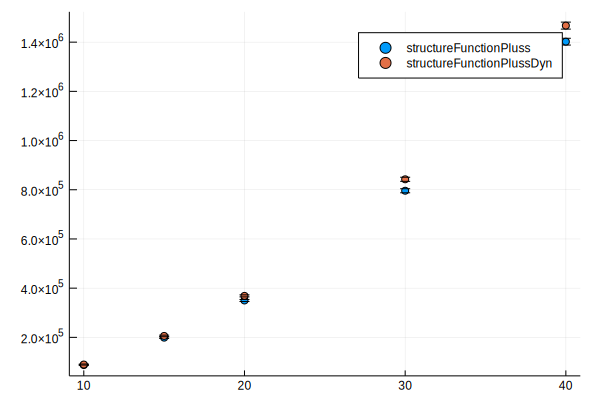

In [22]:
scatter(sizes, m1, err=s1, label="structureFunctionPluss")
scatter!(sizes, m2, err=s2, label="structureFunctionPlussDyn")

# Float multiplication is faster than division

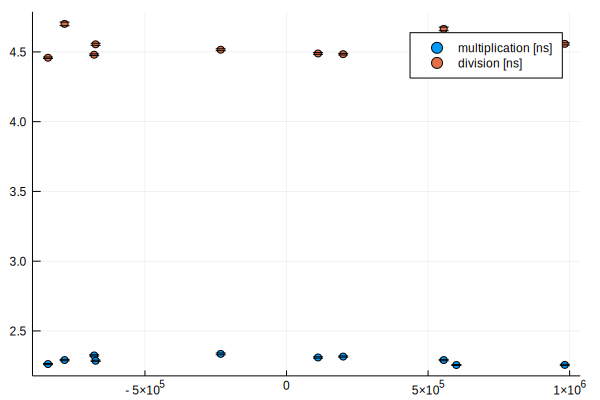

In [19]:
using Plots
gr()
using Distributions
using BenchmarkTools
N = 10 # Numbers to test
mx = 1e6
x = rand(Uniform(-mx,mx), N)
y = [exp(42) for el in x]
y⁻¹ = [1/el for el in y]
mult_means = zeros(N)
mult_err = zeros(N)
div_means = zeros(N)
div_err = zeros(N)
for i=1:N
    div = @benchmark ($x[$i]/$y[$i])
    mult = @benchmark ($x[$i]*$y⁻¹[$i])
    mult_means[i] = mean(mult.times)
    mult_err[i] = std(mult.times)/sqrt(size(mult.times,1))
    div_means[i] = mean(div.times)
    div_err[i] = std(div.times)/sqrt(size(div.times,1))
end
scatter(x, mult_means, err=mult_err, label="multiplication [ns]")
scatter!(x, div_means, err=div_err, label="division [ns]")

We see that float multiplication is far faster than float division.